# 1: import data
# 2: export training 

In [1]:
import os
from dotenv import load_dotenv
from google.cloud import storage

# Load environment variables from a .env file located in the same directory as this script
load_dotenv()

# Now you can access the environment variable
cloud_project = os.getenv("GOOGLE_CLOUD_PROJECT_NAME")
key_path = os.getenv("GOOGLE_CLOUD_KEY_PATH")

# Initialize a Google Cloud Storage client
client = storage.Client()

# Your bucket name
bucket_name = "hotspotstoplight_floodmapping"

# Create a GCS Bucket object
bucket = client.get_bucket(bucket_name)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

In [2]:
import rasterio
from rasterio import windows

gcs_paths = [
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2018-10-02.tif",
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2021-07-22.tif",
]

tile_size = 256

In [3]:
from itertools import product

def get_tiles(ds, width=tile_size, height=tile_size):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

In [4]:
import os

# Directory where you want to save the tiles
output_dir = "costa_rica_temp_outputs"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
# Ensure GDAL is configured to work with GCS URLs
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "YES"
os.environ["CPL_VSIL_CURL_ALLOWED_EXTENSIONS"] = "tif"

In [7]:
import numpy as np

In [8]:
tiles_filenames = []  # This list will store the filenames of all saved tiles


for input_geotiff in gcs_paths:
    with rasterio.open(input_geotiff) as src:
        tile_index = 0
        for window, transform in get_tiles(src):
            # Read band 2 for the current window (tile)
            band2 = src.read(2, window=window)
            
            # Check if band 2 has any non-zero values
            if np.any(band2 != 0):  # If true, proceed to process and save the tile
                tile = src.read(window=window)  # Read all bands for the window
                meta = src.meta.copy()
                meta.update({
                    "driver": "GTiff",
                    "height": window.height,
                    "width": window.width,
                    "transform": transform
                })
                # Generate a unique filename for the tile
                unique_part = input_geotiff.split('/')[-1].replace('.tif', '')
                filename = f'{unique_part}_tile_{tile_index}.tif'
                full_path = os.path.join(output_dir, filename)
                with rasterio.open(full_path, 'w', **meta) as dst:
                    dst.write(tile)
                tiles_filenames.append(full_path)  # Append the full path to the list
            tile_index += 1

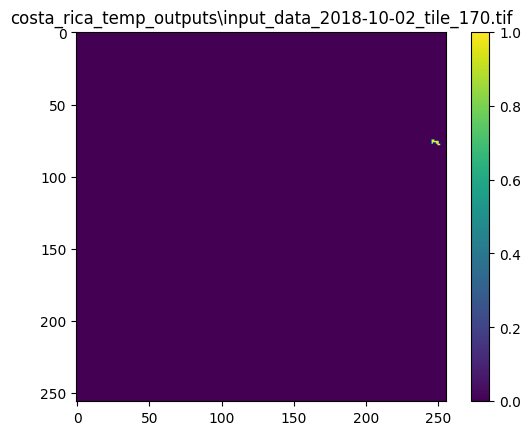

Skipped costa_rica_temp_outputs\input_data_2018-10-02_tile_316.tif because band 7 contains only 0 values.


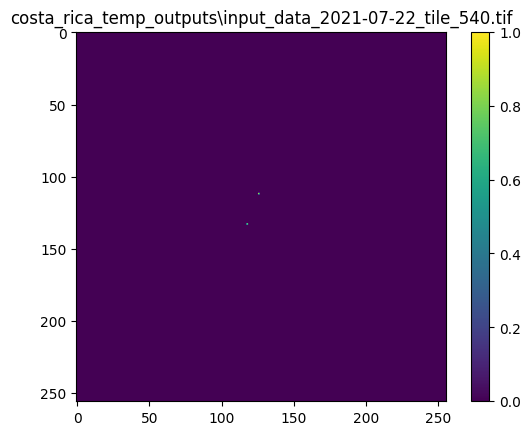

Skipped costa_rica_temp_outputs\input_data_2021-07-22_tile_175.tif because band 7 contains only 0 values.
Skipped costa_rica_temp_outputs\input_data_2018-10-02_tile_605.tif because band 7 contains only 0 values.


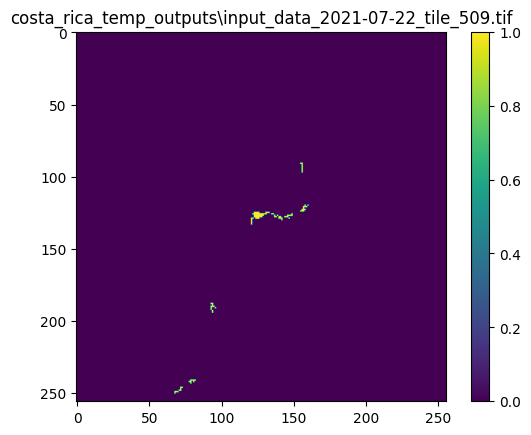

Skipped costa_rica_temp_outputs\input_data_2018-10-02_tile_224.tif because band 7 contains only 0 values.
Skipped costa_rica_temp_outputs\input_data_2018-10-02_tile_570.tif because band 7 contains only 0 values.
Skipped costa_rica_temp_outputs\input_data_2018-10-02_tile_198.tif because band 7 contains only 0 values.
Skipped costa_rica_temp_outputs\input_data_2021-07-22_tile_169.tif because band 7 contains only 0 values.


In [9]:
import random
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Ensure there are enough tiles for sampling
num_samples = min(len(tiles_filenames), 10)
random_tiles = random.sample(tiles_filenames, num_samples)

# Display the randomly selected tiles, filtering out tiles where band 2 has only 0 values
for tile_filename in random_tiles:
    with rasterio.open(tile_filename) as tile:
        data = tile.read(7)  # Read the second band of the tile
        
        # Check if the entire band contains only 0 values
        if np.any(data != 0):  # If there's at least one non-zero value, proceed
            plt.figure()
            plt.imshow(data, cmap='viridis')
            plt.title(tile_filename)
            plt.colorbar()
            plt.show()
        else:
            print(f"Skipped {tile_filename} because band 7 contains only 0 values.")

In [ ]:
# at some point, will want to upload the tiles to GCS

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from torchvision import transforms

In [11]:
# create a subset of the tiles to use; drop the ones that aren't 256x256
valid_tiles_filenames = []
for tile_filename in tiles_filenames:
    with rasterio.open(tile_filename) as tile:
        if tile.shape[0] == 256 and tile.shape[1] == 256:
            valid_tiles_filenames.append(tile_filename)

In [12]:
class CustomGeoDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths  # List of file paths for geospatial data
        self.transform = transform  # Data augmentation/transformations

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Open the geospatial file using Rasterio
        with rasterio.open(self.file_paths[idx], 'r') as src:
            data = src.read()  # Read the data (e.g., satellite imagery)
            # Apply any preprocessing or transformations here
            if self.transform:
                data = self.transform(data)
        return data

In [13]:
# Instantiate the custom dataset
custom_dataset = CustomGeoDataset(valid_tiles_filenames)

In [40]:
# Create a DataLoader for batching and parallel data loading
dataloader = DataLoader(custom_dataset, batch_size=4, shuffle=True)

In [41]:
for batch in dataloader:
    # Perform model training or inference with the batch data
    # Make sure your model is compatible with the input data format
    
    # For demonstration purposes, we will just print the batch shape
    print("Batch shape:", batch.shape)
    break

Batch shape: torch.Size([4, 16, 256, 256])


In [42]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 128 * 128, out_features=40960)  # Adjusted the output size of fc1

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
# Instantiate the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    for batch in dataloader:
        # Forward pass
        inputs, targets = batch[:, :5, :, :], batch[:, 6:, :, :]  # Exclude band 2 from inputs
        outputs = model(inputs.float())

        # Resize targets to match the shape of outputs
        # Resize targets to match the shape of outputs
        targets_resized = nn.functional.interpolate(targets.float(), size=(64, 64))  # Assuming output size is 64x64


        # Flatten the tensors to match the output tensor shape
        outputs_flattened = outputs.view(outputs.size(0), -1)
        targets_flattened = targets_resized.view(targets_resized.size(0), -1)

        
        print("Output flattened shape:", outputs_flattened.shape)
        print("Target flattened shape:", targets_flattened.shape)
        
        loss = criterion(outputs_flattened, targets_flattened)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 42949672960 bytes.